# Time Series forecast with tensorflow

refs: 
* https://www.tensorflow.org/tutorials/structured_data/time_series
* https://www.tensorflow.org/guide/data


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
# enable eager execution . should be done in program startup
# refs: 1.10 https://dongnanzhy.github.io/2019/01/06/dcgan/
# refs: https://medium.com/coding-blocks/eager-execution-in-tensorflow-a-more-pythonic-way-of-building-models-e461810618c8
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import pathlib 

import datetime

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
!pwd
tf.__version__

/media/leandroohf/sdb1/leandro/time_series_forecast_with_tensorflow/dev


'2.0.0'

* enable eager executuion

refs: https://medium.com/coding-blocks/eager-execution-in-tensorflow-a-more-pythonic-way-of-building-models-e461810618c8


In [ ]:
## enable eager execution

# tf 2.0 eager are enable by default. But not in 1.0
tf.executing_eagerly()

tf.constant([[1,0],[0,1]],dtype=float)

In [4]:
# loading tensorboard
%load_ext tensorboard

In [ ]:
# creates log dir
#!mkdir -p logs

# Clear any logs from previous runs
!rm -rvf ./logs/ 

## Setting conda enviromewnt




```sh
# Create env 
conda create -n tensorflow-timeseries

# activate env
conda activate tensorflow-timeseries

# install tensorflow 2.0 
pip install tensorflow # now is default in pip
python -c "import tensorflow as tf; print(tf.__version__)"

# enable the env in jupyter notebook
conda install ipykernel

# normally jupyter will automatic detect alll conda envs. INcase it fail you can add
python -m ipykernel install --user --name=tensorflow-timeseries

# install tensorboard
pip install -q tf-nightly-2.0-preview

# deactivate 
conda deactivate

# generate yaml file
conda env export > tensorflow-timeseries.yaml 

# create env from yaml
conda env create -f tensorflow-timeseries.yaml 

```

In [ ]:
!conda list

## The weather dataset

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected **every 10 minutes**, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path, ext = os.path.splitext(zip_path)

print(csv_path)
print(ext)

!mkdir -p ../data
!cp -v {zip_path} ../data
!unzip -o ../data/jena_climate_2009_2016.csv.zip -d ../data
!tree -n 1 ../data

In [5]:
csv_path = '../data/jena_climate_2009_2016.csv'
df = pd.read_csv(csv_path)
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


The func bellow returns a window of obsrvations data 
* history_size: is the size of the past window of information
* target_size is how far in the future does the model need to learn to predict

For instance: 5 days obeservations is a window with hitory_size = 6720 (2x6*24)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        
        indices = range(i-history_size, i)
        
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

The func belows plot thw train data and the predict point

In [15]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
        
    return time_steps

def show_plot(plot_data, delta, title):
    
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        
        if i:
            
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
            
    return plt

 Split data in train and validation dataset
 * train 300k observations
 * validation: ~2100 (remains)
 

In [6]:
TRAIN_SPLIT = 300000

#tf.set_random_seed(13)
tf.random.set_seed(13) # tf core 2.0

## Forecast a univariate time series

In [ ]:
uni_data_df = df['T (degC)']
uni_data_df.index = df['Date Time']
uni_data_df.head()

uni_data_df.plot(subplots=True)

* normalize data for the NN.

In [ ]:
uni_data = uni_data_df.values
uni_data

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data

Lets use the last **20 recorded temperature observations**, and predict the temperature at the next time step (one observation)

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print(x_train_uni.shape)
print (x_train_uni[0])
print ('\n Target temperature to predict')
print(y_train_uni.shape)
print (y_train_uni[0])

print('validation dataset')
print(x_val_uni.shape)
print(y_val_uni.shape)

In [ ]:
# next time step prediction 
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
# next time step prediction is mean compared to zero
np.mean(x_train_uni[0])
show_plot([x_train_uni[0], y_train_uni[0], np.mean(x_train_uni[0])], 0,
           'Baseline Prediction Example')

### Understand first tf.data api

refs: https://www.tensorflow.org/guide/data



* tf.data API

Tensorflow provide a pipeli API called tf.data that can provide methods to handle different type of data.  For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths.


The tf.data API supports a **variety of file formats so that you can process large datasets that do not fit in memory**

* tf.data.Dataset

tf.data.Dataset abstraction that represents a **sequence of elements**, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

if your input data is stored in a file in the recommended TFRecord format, you can use **tf.data.TFRecordDataset()**

    * tf.data.Dataset.element_spec property allows you to inspect the type of each element component


See examples bellow

In [ ]:
# Example of create Dataset from memory 
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

counter = 0
for elem in dataset:
    counter += 1
    print(elem.numpy())
    
print('counter: {}'.format(counter))
    
rd = tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32)

rd.shape

dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1
print()
dataset1.element_spec

counter = 0
for elem in dataset1:
    counter += 1
    
print('counter: {}'.format(counter))
    

print()
# Load dataset
train, test = tf.keras.datasets.fashion_mnist.load_data()


images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

See examples bellow how to read from files

In [ ]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

# Download examples
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

flowers_root = pathlib.Path(flowers_root)

In [ ]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file ])
dataset

Consuming a list of files

In [ ]:
# see folders contents
for item in flowers_root.glob("*"):
    print(item.name)

print()
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())
    

print()
# Convert the file paths to (image, label) pairs:
def process_path(file_path):
    
    parts = tf.strings.split(file_path, '/')
    return tf.io.read_file(file_path), parts[-2]

labeled_ds = list_ds.map(process_path)

for image_raw, label_text in labeled_ds.take(2):
    print(repr(image_raw.numpy()[:100]))
    print()
    print(label_text.numpy())
    print('========== next image ===========')

### Data wrangling




* **tf.data.Dadaset.cache(filename='')**

Caches the elements in this dataset. filename representing the name of a directory on the filesystem to use for caching elements in this Dataset. **If a filename is not provided, the dataset will be cached in memory.**

* **tf.data.Dadaset.shuffle(buffer_size,seed=None,reshuffle_each_iteration=None)**

Randomly shuffles the elements of this dataset. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. **For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.**

* **tf.data.Dadaset.batch(batch_size, drop_remainder=False)**

Combines consecutive elements of this dataset into batches. (Group of elemenst or sequences)

* **tf.data.Dadaset.batch(count=None)**

Repeats this dataset count times. The default behavior (if count is None or -1) is for the dataset be repeated indefinitely.


**Let's shuffle, batch, and cache the train dataset.**


<img src="../fig/tf_data_shuffle.png" width="500" align="left"/> 


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

x_train_uni.shape
y_train_uni.shape 

print('#batches: {}'.format(int(x_train_uni.shape[0]/BATCH_SIZE)))

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

type(train_univariate)
train_univariate
train_univariate.list_files


print('Train dataset: Understanding batch data')
# Understand the dim of the data
for x, y  in train_univariate.take(1):
    print(x.shape)
    print(y.shape)
    
print()
print('Val dataset: Understanding batch data')
# Understand the dim of the data
for x, y  in val_univariate.take(1):
    print(x.shape)
    print(y.shape)


# for x, y in val_univariate.take(1):
#     print(simple_lstm_model.predict(x).shape)

### Training  simple LSTM

LSTM is a subtyep of RNN


outputs of one neuron:  

$
c_t = f(c_{t-1}, x_t, h_{t-1})
$

$
h_t = g(c_{t}, x_t)
$

<img src="../fig/lstm_neuron.png" width="600" align="left"/> 



In [ ]:
log_dir="logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# LSTM 
# #neuron in Layer: 8
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

# seting loss n optmizer
#simple_lstm_model.compile(optimizer='adam', loss='mae')

adam = tf.keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.summary()

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50,
                      callbacks=[tensorboard_callback])

In [ ]:
time_step = 0
for x, y in val_univariate.take(1):
    print(x.shape)
    print(y.shape)
#simple_lstm_model.predict(x)[0]

Start tensorboard

refs: https://www.tensorflow.org/tensorboard/get_started

run in the command line 

```sh
tensorboard --logdir logs/fit1
```


* The Scalars dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.

* The Graphs dashboard helps you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly. 

* The Distributions and Histograms dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.

### Predictions

In [ ]:
time_step = 0
for x, y in val_univariate.take(5):
    
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], time_step, 'Simple LSTM model')
    plot.show()

In [ ]:
%tensorboard --logdir logs/fit1

## Forecast a multivariate time series: One step model

720 observations that are sampled every hour.  Ex: 120 observation represent history of the last five days


**The goal is to predict temprature based on 5 days observations of 3 features**

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2012fd5f50>,
      dtype=object)

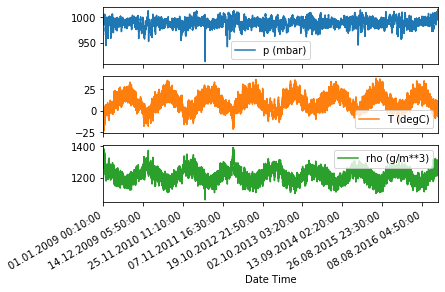

In [8]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head(3)

print()
features.plot(subplots=True)

* normalize data 

### Data wrangling

In [9]:
dataset = features.values

data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

dataset = (dataset-data_mean)/data_std

dataset.shape

(420551, 3)

In a single step setup, the model learns to predict a single point in the future based on some history provided.


In [10]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): 
        
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print ('Single window of past history : {}'.format(x_train_single[0].shape))
y_train_single.shape
print ('Single window of past history : {}'.format(x_val_single[0].shape))

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

type(train_data_single)
train_data_single

print('Train dataset: Understanding batch data')
# Understand the dim of the data
for x, y  in train_data_single.take(1):
    print(x.shape)
    print(y.shape)
    
print()
print('Val dataset: Understanding batch data')
# Understand the dim of the data
for x, y  in val_data_single.take(1):
    print(x.shape)
    print(y.shape)

### Training model

In [ ]:
log_dir="logs/fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

single_step_model = tf.keras.models.Sequential()

# understand inputs shapes
x_train_single.shape
x_train_single.shape[-2:]

# LSTM 
# # #neuron in Layer: 8
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


single_step_model.summary()

In [ ]:
# test sample predition
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

* training

**How to resatart from zero the model whithout change paramneters?** Should I delete the object or restart the notebook?



**TODO:** fix it latter
**This model has high variance problem*** If you trainn longer the validation loss is increasing.


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50,
                                            callbacks=[tensorboard_callback])


 
 First models the validation loss start increasing indicating that we should try to reduce variance erro and not bias. **Because of that we reduce EPOCHS to 10**
 
 <img src="../fig/variance_error_increasing.png" width="400" align="left"/>  
 

In [7]:
def plot_train_history(history, title):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

### Predictions

The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction).

In [ ]:
for x, y in val_data_single.take(3):
    
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
plot.show()

## Forecast a multivariate time series: Multiple step model

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model **predict a sequence of the future.**

The training data again consists of recordings **over the past five days sampled every hour**. However, here, the model needs to **learn to predict the temperature for the next 12 hours**. Since an obversation is taken every 10 minutes, the output is 72 predictions.


### Data wrangling

In [11]:
past_history = 720
future_target = 72
STEP = 6

BATCH_SIZE = 256
BUFFER_SIZE = 10000

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [12]:
def multi_step_plot(history, true_future, prediction):

    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
        
    plt.legend(loc='upper left')
    plt.show()

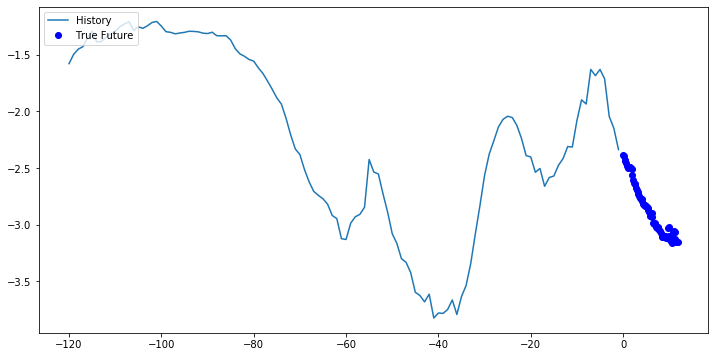

In [16]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Train model

In [17]:
log_dir="logs/fit3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))

multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

multi_step_model.add(tf.keras.layers.Dense(72))


# defaults valueas of thwe optmizer
# __init__(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,
#     name='RMSprop',
# )

rms_prop = tf.keras.optimizers.RMSprop(clipvalue=1.0, learning_rate=0.0001)

print('Optmizer parmeters: ')
print('lr: {}'.format(rms_prop.learning_rate))
print('rho: {}'.format(rms_prop.rho))
print('momentum: {}'.format(rms_prop.momentum))
print('epsilon: {}'.format(rms_prop.epsilon))

multi_step_model.compile(optimizer=rms_prop, loss='mae')

print('input size:{}'.format(x_train_multi.shape[-2:]))

multi_step_model.summary()

# checking prediction output size
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

Optmizer parmeters: 
lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
rho: <tf.Variable 'rho:0' shape=() dtype=float32, numpy=0.9>
momentum: <tf.Variable 'momentum:0' shape=() dtype=float32, numpy=0.0>
epsilon: 1e-07
input size:(120, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________
(256, 72)


In [28]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[tensorboard_callback])


Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - 40s 202ms/step - loss: 0.1966 - val_loss: 0.1935
Epoch 2/5
200/200 [==============================] - 38s 189ms/step - loss: 0.1968 - val_loss: 0.1918
Epoch 3/5
200/200 [==============================] - 37s 186ms/step - loss: 0.2067 - val_loss: 0.1934
Epoch 4/5
200/200 [==============================] - 32s 158ms/step - loss: 0.2029 - val_loss: 0.1898
Epoch 5/5
200/200 [==============================] - 35s 174ms/step - loss: 0.1813 - val_loss: 0.1874


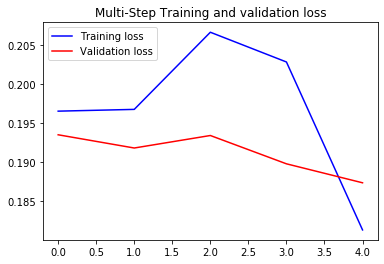

In [29]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


### Predictions

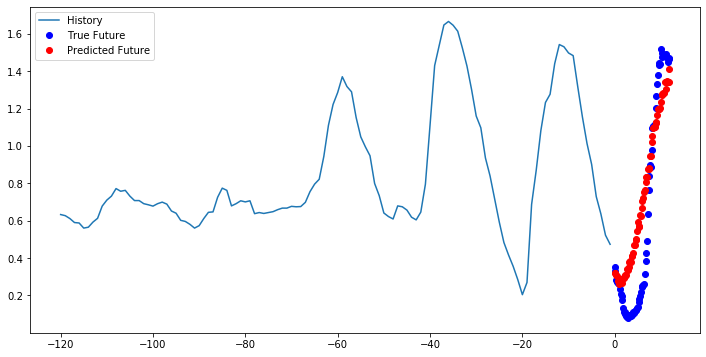

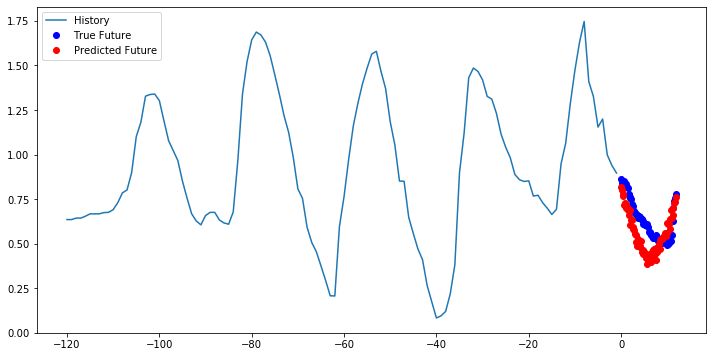

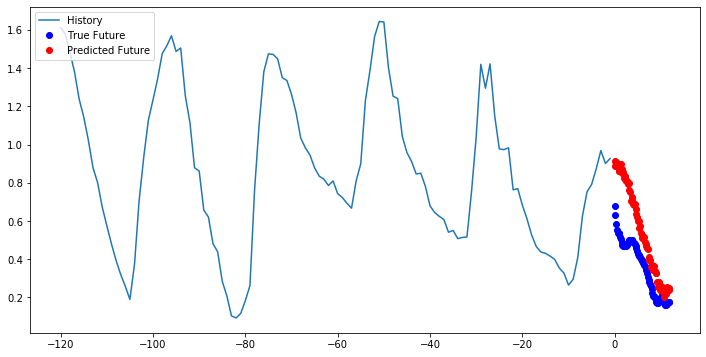

In [30]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])